<a href="https://colab.research.google.com/github/epigos/learning-pytorch/blob/master/notebooks/03-CNN-Image-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import copy
import warnings
from collections import defaultdict, deque
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print('Device name:', torch.cuda.get_device_name())

Device name: Tesla P100-PCIE-16GB


# Load CIFAR10 data

In [3]:
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load train and validation set
dataset = datasets.CIFAR10('./data', download=True, train=True, transform=transform)
train_set, val_set = data.random_split(dataset, [40000, 10000])  # split into train and val set

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
# load test set
test_set = datasets.CIFAR10('./data', download=True, train=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(f"Number of training images: {len(train_set)}")
print(f"Number of validation images: {len(val_set)}")
print(f"Number of testing images: {len(test_set)}")
print(f"Size of each image: {train_set[0][0].size()}")
data_loader = {'train': train_loader, 'val': val_loader}

Number of training images: 40000
Number of validation images: 10000
Number of testing images: 10000
Size of each image: torch.Size([3, 32, 32])


## Show some images

In [0]:
def imshow(img, ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

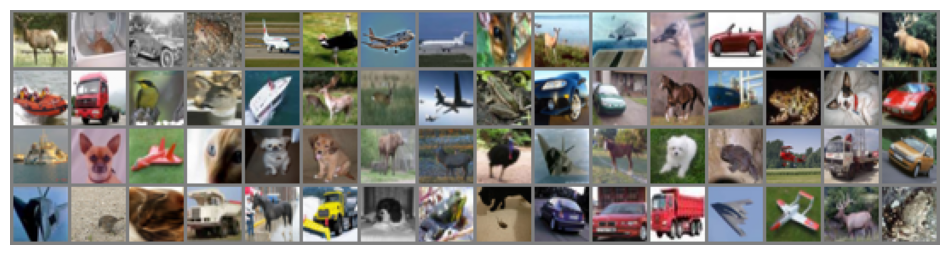

In [6]:
# get some random training images
data_iter = iter(data_loader['train'])
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(BATCH_SIZE/4))
imshow(grid, ax=ax)

In [7]:
# classes
categories = dataset.class_to_idx
output_size = len(categories)
categories

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

# Convoluational Neural Network

In [0]:
class CNN(nn.Module):
    def __init__(self, output_size=output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# test network
cnn(torch.rand(1, 3, 32, 32))

tensor([[-0.0710, -0.0335, -0.0184,  0.0126,  0.0418,  0.0624, -0.0298,  0.0902,
         -0.0437, -0.1208]], grad_fn=<AddmmBackward>)

## Train the network

In [0]:
def train(model, data_loader, epochs=5, lr=1e-2, momentum=0.9):
    model = model.to(device)
    # define training function
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    # define loss function
    criterion = nn.CrossEntropyLoss()
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = defaultdict(lambda: deque(maxlen=epochs))
    accuracy_history = defaultdict(lambda: deque(maxlen=epochs))

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 60)    

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # make predictions
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs.data, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                total += labels.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_history[phase].append(epoch_loss)
            accuracy_history[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
            

    time_elapsed = time.time() - since
    print('-' * 60)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.3f} %'.format(100 * best_acc))
    print('=' * 60, '\n')
    # load best weights
    model.load_state_dict(best_weights)
    return loss_history, accuracy_history

In [12]:
loss_history, accuracy_history = train(cnn, data_loader)

Epoch 1/5
------------------------------------------------------------
train Loss: 1.9650 Acc: 0.2588
val Loss: 1.6913 Acc: 0.3849
Epoch 2/5
------------------------------------------------------------
train Loss: 1.5154 Acc: 0.4451
val Loss: 1.4061 Acc: 0.4982
Epoch 3/5
------------------------------------------------------------
train Loss: 1.3374 Acc: 0.5195
val Loss: 1.3299 Acc: 0.5222
Epoch 4/5
------------------------------------------------------------
train Loss: 1.2176 Acc: 0.5649
val Loss: 1.2108 Acc: 0.5734
Epoch 5/5
------------------------------------------------------------
train Loss: 1.1246 Acc: 0.5999
val Loss: 1.1736 Acc: 0.5888
------------------------------------------------------------
Training complete in 0m 48s
Best val Acc: 58.880 %



## Visualize training performance

In [0]:
def plot_learning_curve(loss_history, accuracy_history, figsize=(12, 4)):

    x_values = range(1, len(loss_history['train'])+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharex=True)
    lines = dict(train='--', val='-')

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax1.plot(x_values, loss_history[phase], lines[phase],  label=f"{label}")

    plt.sca(ax1)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Loss")

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax2.plot(x_values, accuracy_history[phase], lines[phase], label=f"{label}")

    plt.sca(ax2)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Accuracy")
    _ = plt.suptitle(f"Training Performance\n")
    _ = plt.subplots_adjust(top=0.9)
    plt.show()

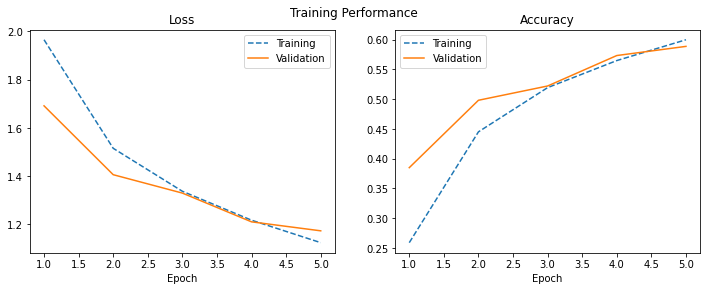

In [14]:
plot_learning_curve(loss_history, accuracy_history)

## Evaluate model

In [15]:
# convert dataset ids to classes
idx_to_class = {v:k for k,v in categories.items()}
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def plot_confusion_matrix(y_true, y_pred, labels, normalize=None, 
                          title='Confusion matrix', cmap=plt.cm.Blues, ax=None):
    """
    Function to plot confusion matrix.
    Adapted from: https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/metrics/_plot/confusion_matrix.py#L119
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp = disp.plot(cmap=cmap, ax=ax)
    _ = disp.ax_.set_title(title)
    disp.ax_.grid(False)
    return disp.ax_


def predict(model, test_loader):
    """Function to predict test data"""
    correct, total = 0, 0
    targets = []
    predictions = []

    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
        
            total += labels.size(0)
            correct += (predicted ==labels).sum().item()
            # append labels
            targets.extend(labels.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())

    score = correct / total
    targets = [idx_to_class[i] for i in targets]
    predictions = [idx_to_class[i] for i in predictions]
    return score, targets, predictions

In [0]:
# make test predictions
score, y_true, y_pred = predict(cnn, test_loader)

In [18]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 58.45 %


In [19]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    airplane       0.77      0.51      0.61      1000
  automobile       0.82      0.58      0.68      1000
        bird       0.45      0.56      0.49      1000
         cat       0.36      0.54      0.43      1000
        deer       0.55      0.47      0.51      1000
         dog       0.55      0.38      0.45      1000
        frog       0.70      0.66      0.68      1000
       horse       0.72      0.60      0.66      1000
        ship       0.63      0.80      0.70      1000
       truck       0.59      0.74      0.66      1000

    accuracy                           0.58     10000
   macro avg       0.61      0.58      0.59     10000
weighted avg       0.61      0.58      0.59     10000




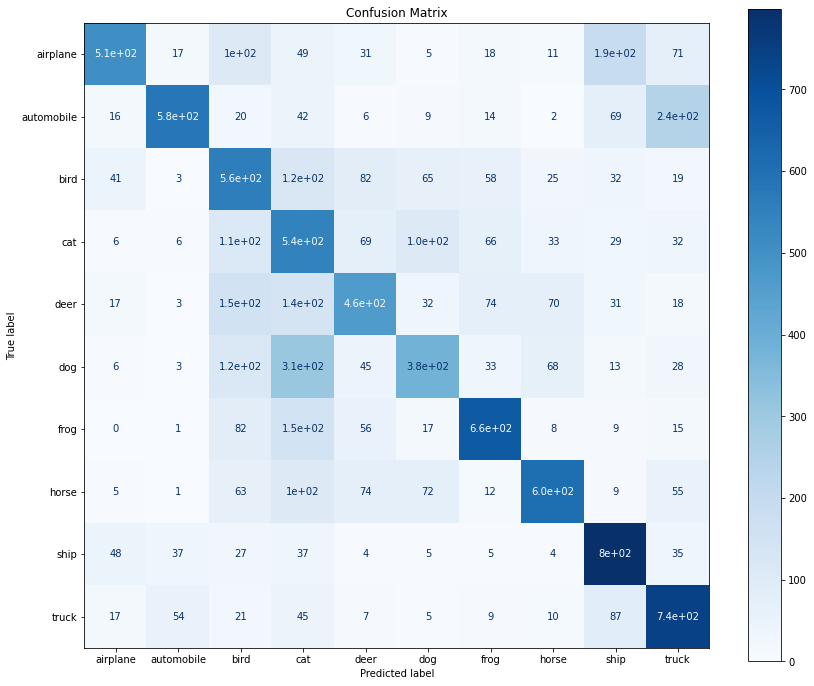

In [20]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [0]:
# save model
torch.save({
    'state_dict': cnn.state_dict(),
    'idx_to_class': idx_to_class,
}, './cifar10_cnn.pth')

In [22]:
!ls -lh cifar10_cnn.pth

-rw-r--r-- 1 root root 244K Jun  7 15:28 cifar10_cnn.pth


# Using Pretrained models

In [23]:
# Use alexnet model without pretrained weights
alexnet = torchvision.models.alexnet(num_classes=output_size, pretrained=False)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
# reload and resize images
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load train and validation set
dataset = datasets.CIFAR10('./data', download=True, train=True, transform=transform)
train_set, val_set = data.random_split(dataset, [40000, 10000])  # split into train and val set

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
# load test set
test_set = datasets.CIFAR10('./data', download=True, train=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

print(f"Number of training images: {len(train_set)}")
print(f"Number of validation images: {len(val_set)}")
print(f"Number of testing images: {len(test_set)}")
print(f"Size of each image: {train_set[0][0].size()}")
data_loader = {'train': train_loader, 'val': val_loader}

Files already downloaded and verified
Files already downloaded and verified
Number of training images: 40000
Number of validation images: 10000
Number of testing images: 10000
Size of each image: torch.Size([3, 227, 227])


In [0]:
# classes
categories = dataset.class_to_idx
output_size = len(categories)

## Train model

In [26]:
loss_history, accuracy_history = train(alexnet, data_loader)

Epoch 1/5
------------------------------------------------------------
train Loss: 1.9071 Acc: 0.2866
val Loss: 1.5020 Acc: 0.4385
Epoch 2/5
------------------------------------------------------------
train Loss: 1.3319 Acc: 0.5157
val Loss: 1.1828 Acc: 0.5841
Epoch 3/5
------------------------------------------------------------
train Loss: 1.0376 Acc: 0.6336
val Loss: 0.9100 Acc: 0.6819
Epoch 4/5
------------------------------------------------------------
train Loss: 0.8553 Acc: 0.7018
val Loss: 0.8087 Acc: 0.7199
Epoch 5/5
------------------------------------------------------------
train Loss: 0.7316 Acc: 0.7460
val Loss: 0.7713 Acc: 0.7352
------------------------------------------------------------
Training complete in 8m 19s
Best val Acc: 73.520 %



## Visualize training performance

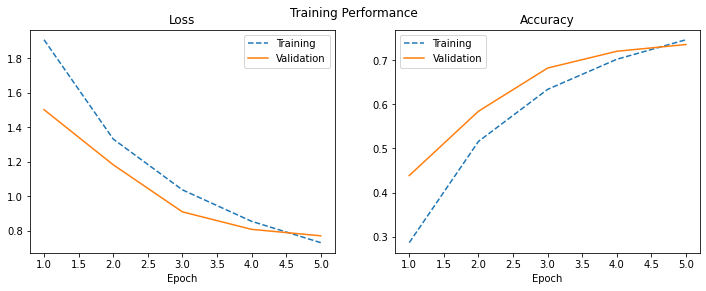

In [27]:
plot_learning_curve(loss_history, accuracy_history)

Needs more epochs to converge

## Evaluate model

In [0]:
# make test predictions
score, y_true, y_pred = predict(alexnet, test_loader)

In [29]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 74.40 %


In [30]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    airplane       0.76      0.82      0.79      1000
  automobile       0.80      0.92      0.85      1000
        bird       0.78      0.56      0.65      1000
         cat       0.58      0.63      0.60      1000
        deer       0.69      0.61      0.65      1000
         dog       0.76      0.59      0.67      1000
        frog       0.85      0.80      0.82      1000
       horse       0.60      0.92      0.72      1000
        ship       0.88      0.80      0.84      1000
       truck       0.88      0.80      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.76      0.74      0.74     10000
weighted avg       0.76      0.74      0.74     10000




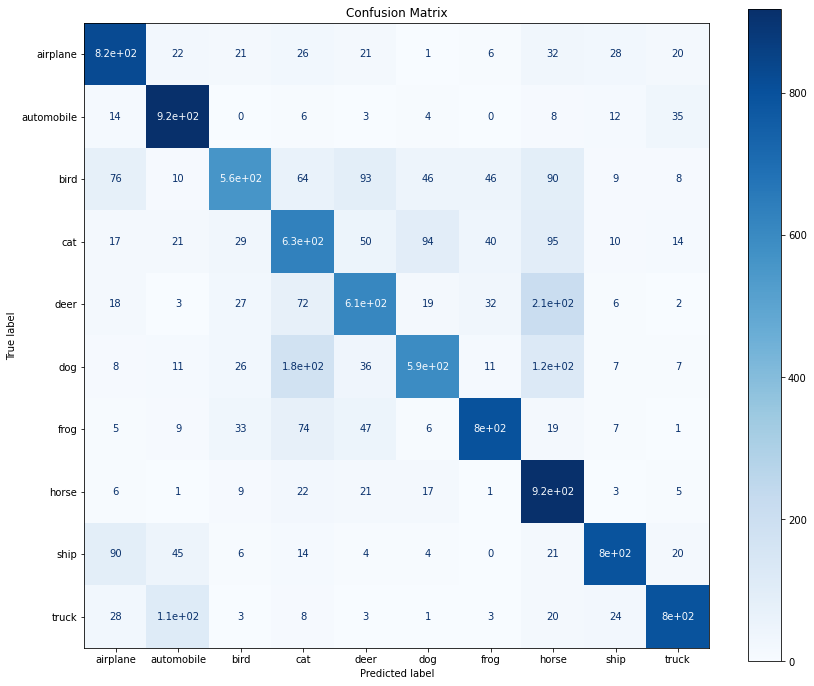

In [31]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [0]:
# save model
torch.save({
    'state_dict': alexnet.state_dict(),
    'idx_to_class': idx_to_class,
}, './cifar10_alexnet.pth')

# Transfer learning using ResNet

In [33]:
# Load resnet with pretrained weights
resnet = torchvision.models.resnet50(pretrained=True)
# freeze training of trained parameters except batch normalization layers
for name, param in resnet.named_parameters():
    if ("bn" not in name):  # skip batch norm layers
        param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [34]:
# view frozen layers
for name, param in resnet.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight True
bn1.bias True
layer1.0.conv1.weight False
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight False
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight False
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight False
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight False
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight False
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight False
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight False
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight False
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight False
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.con

In [0]:
# connect Fully connected layers for classifying the images
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, output_size)
)

In [36]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train model

In [37]:
loss_history, accuracy_history = train(resnet, data_loader)

Epoch 1/5
------------------------------------------------------------
train Loss: 0.4266 Acc: 0.8566
val Loss: 0.1996 Acc: 0.9302
Epoch 2/5
------------------------------------------------------------
train Loss: 0.2033 Acc: 0.9324
val Loss: 0.1982 Acc: 0.9338
Epoch 3/5
------------------------------------------------------------
train Loss: 0.1640 Acc: 0.9455
val Loss: 0.1718 Acc: 0.9413
Epoch 4/5
------------------------------------------------------------
train Loss: 0.1417 Acc: 0.9513
val Loss: 0.1554 Acc: 0.9465
Epoch 5/5
------------------------------------------------------------
train Loss: 0.1295 Acc: 0.9570
val Loss: 0.1550 Acc: 0.9483
------------------------------------------------------------
Training complete in 21m 12s
Best val Acc: 94.830 %



## Visualize training performance

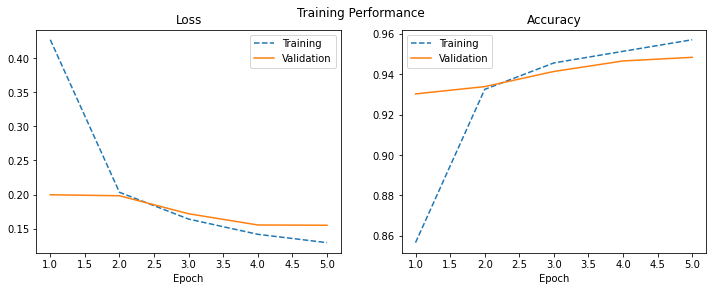

In [38]:
plot_learning_curve(loss_history, accuracy_history)

## Evaluate model

In [44]:
# make test predictions
%%time
score, y_true, y_pred = predict(resnet, test_loader)

CPU times: user 24.8 s, sys: 6.39 s, total: 31.2 s
Wall time: 31.2 s


In [45]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 94.33 %


In [46]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    airplane       0.94      0.95      0.95      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.94      0.93      0.94      1000
         cat       0.93      0.83      0.88      1000
        deer       0.94      0.95      0.95      1000
         dog       0.91      0.92      0.91      1000
        frog       0.95      0.97      0.96      1000
       horse       0.94      0.97      0.95      1000
        ship       0.93      0.98      0.96      1000
       truck       0.98      0.94      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000




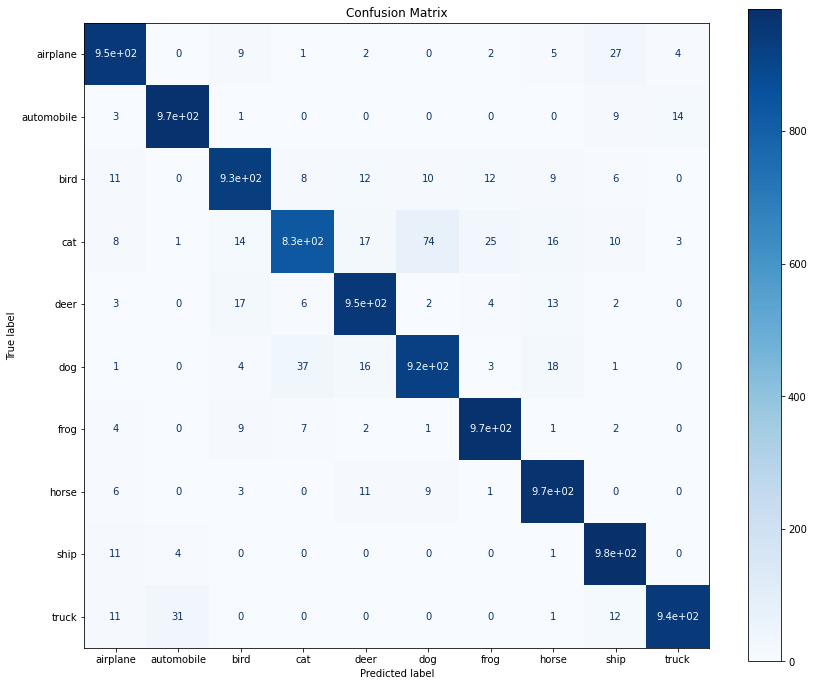

In [47]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [0]:
# save model
torch.save({
    'state_dict': resnet.state_dict(),
    'idx_to_class': idx_to_class,
}, './cifar10_resnet.pth')